### Import Packages


In [ ]:
import os
import csv
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print(torch.__version__)

2.1.0+cu118


### MNIST dataset is provided in default

In [ ]:
train_path = './sample_data/mnist_train_small.csv'
test_path = './sample_data/mnist_test.csv'
img_size = 28

### Choose your device - use GPU or not?

In [ ]:
# device = 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Current Device : {}'.format(device))

Current Device : cuda


### Read the MNIST dataset
- total 1+ 28x28 dimension. 1 For Label, 28**2 for image


In [ ]:
def mnist_reader(file_path, img_size=img_size):
    total_img = list()
    total_label = list()
    with open(file_path) as csvfile:
        mnist_reader = csv.reader(csvfile)
        for row in tqdm(mnist_reader):
            img = np.array(row[1:], dtype=np.uint16).reshape(img_size, img_size)
            img = (img / 255) * 2 - 1 # pixel ranges from -1 to 1.
            label = int(row[0])

            total_img.append(img)
            total_label.append(label)

    total_img = np.asarray(total_img)
    total_label = np.asarray(total_label)

    return total_img, total_label

In [ ]:
train_img, train_label = mnist_reader(train_path)
test_img, test_label = mnist_reader(test_path)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
all_img = np.concatenate([train_img, test_img], axis=0)
all_label = np.concatenate([train_label, test_label], axis=0)

target_idx = 3
target_img = all_img#[all_label==target_idx]
target_label = all_label#[all_label==target_idx]

### Define the Dataset

In [ ]:
class MNIST_Dataset(Dataset):
    def __init__(self, target_img, target_label):
        self.target_img = target_img
        self.target_label = target_label
        self.num_data = target_img.shape[0]

    def __len__(self):
        return self.num_data

    def __getitem__(self, idx):
        sample = dict()
        sample['img'] = self.target_img[idx]
        sample['label'] = self.target_label[idx]

        return sample

### Define the DataLoader

In [ ]:
batch_size = 512

train_dataset = MNIST_Dataset(target_img, target_label)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### Try to sample out one data point from dataloader

In [ ]:
sample = next(iter(train_dataloader))
print(sample['img'].shape)
print(sample['label'].shape)

torch.Size([512, 28, 28])
torch.Size([512])


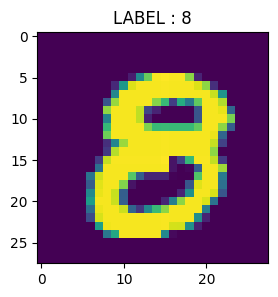

In [ ]:
plot_idx = 0
fig = plt.figure(figsize=(3, 3))
plt.imshow(sample['img'][plot_idx])
plt.title('LABEL : {}'.format(sample['label'][plot_idx]))
plt.show()

### Define the GAN (Generator + Discriminator)


In [ ]:
class Generator(nn.Module):
    def __init__(self, dim_hidden_1, dim_hidden_2, dim_z, dim_input=img_size**2):
        super(Generator, self).__init__()

        # define hidden dimension
        self.dim_hidden_1 = dim_hidden_1
        self.dim_hidden_2 = dim_hidden_2
        self.dim_z = dim_z
        self.dim_input = dim_input

        # define generator : dim_z -> dim_input.
        self.fc_1 = nn.Linear(dim_z, dim_hidden_1)
        self.fc_2 = nn.Linear(dim_hidden_1, dim_hidden_2)
        self.fc_3 = nn.Linear(dim_hidden_2, dim_input)

        self.bn_1 = nn.BatchNorm1d(dim_hidden_1)
        self.bn_2 = nn.BatchNorm1d(dim_hidden_2)

        self.activation = nn.LeakyReLU(0.1)

    def forward(self, z):
        out = self.activation(self.bn_1(self.fc_1(z)))
        out = self.activation(self.bn_2(self.fc_2(out)))
        out = torch.tanh(self.fc_3(out))
        # tanh because data should be -1 to 1.

        return out

class Discriminator(nn.Module):
    def __init__(self, dim_hidden_1, dim_hidden_2, dim_input=img_size**2):
        super(Discriminator, self).__init__()

        # define hidden dimension
        self.dim_hidden_1 = dim_hidden_1
        self.dim_hidden_2 = dim_hidden_2
        self.dim_input = dim_input

        # define discriminator
        self.fc_1 = nn.Linear(dim_input, dim_hidden_1)
        self.fc_2 = nn.Linear(dim_hidden_1, dim_hidden_2)
        self.fc_3 = nn.Linear(dim_hidden_2, 1)

        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x):
        # x needs to be flatted into B by D
        # x : B x D
        B = x.shape[0]
        x = x.reshape(B, -1)
        out = self.activation(self.fc_1(x))
        out = self.activation(self.fc_2(out))
        out = self.fc_3(out) # B by 1.

        # squeeze(1) eliminates '1' in the shape B by 1. => B
        return torch.sigmoid(out).squeeze(1) # B dim vector.


### Define the Model

In [ ]:
dim_hidden_1 = 256
dim_hidden_2 = 512
dim_z = 128
generator = Generator(dim_hidden_1, dim_hidden_2, dim_z).to(device)
discriminator = Discriminator(dim_hidden_1, dim_hidden_2).to(device)

gen_optimizer = optim.Adam(generator.parameters(), lr=2e-5, betas=(0.5, 0.999))
dis_optimizer = optim.Adam(discriminator.parameters(), lr=1e-5, betas=(0.5, 0.999))

print(generator)
print(discriminator)

Generator(
  (fc_1): Linear(in_features=128, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=512, bias=True)
  (fc_3): Linear(in_features=512, out_features=784, bias=True)
  (bn_1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): LeakyReLU(negative_slope=0.1)
)
Discriminator(
  (fc_1): Linear(in_features=784, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=512, bias=True)
  (fc_3): Linear(in_features=512, out_features=1, bias=True)
  (activation): LeakyReLU(negative_slope=0.1)
)


### Define functions for train/test

In [ ]:
def train(generator, discriminator, gen_optimizer, dis_optimizer, dim_z, sample):
    # sample['img']  B by 28 by 28.
    batch_size = sample['img'].shape[0] #B.

    # -(x log (x') + (1-x) log (1-x')) [x: gt, x': pred.]
    criterion = nn.BCELoss()

    # [1, 1, 1, 1,.... 1]
    real_label = torch.ones(batch_size).to(device)

    # [0, 0, 0, 0,.... 0]
    fake_label = torch.zeros(batch_size).to(device)

    sample_z = torch.randn(batch_size, dim_z).to(device)

    # B by 28**2
    real_img = sample['img'].float().to(device).view(batch_size, -1)
    fake_img = generator(sample_z)

    # Train Generator
    generator.train()
    gen_optimizer.zero_grad()

    g_loss = criterion(discriminator(fake_img), real_label)

    g_loss.backward()
    gen_optimizer.step()

    # Train Discriminator
    discriminator.train()
    dis_optimizer.zero_grad()

    real_loss = criterion(discriminator(real_img), real_label)
    fake_loss = criterion(discriminator(fake_img.detach()), fake_label)
    d_loss = (real_loss + fake_loss) / 2

    d_loss.backward()
    dis_optimizer.step()

    return g_loss.item(), d_loss.item()


In [ ]:
def test(generator, img_size, dim_z, seed):
    generator.eval()
    with torch.no_grad():
        torch.manual_seed(seed)
        sample_z = torch.randn(1, dim_z).to(device)
        fake_data = generator(sample_z.to(device))

    return 0.5*(fake_data.view(img_size, img_size).detach().cpu().numpy() + 1)

### Run Training

  0%|          | 0/1000 [00:00<?, ?it/s]

[EPOCH 0] SAMPLED G LOSS : 0.5692059397697449, SAMPLED D LOSS : 0.6234400868415833


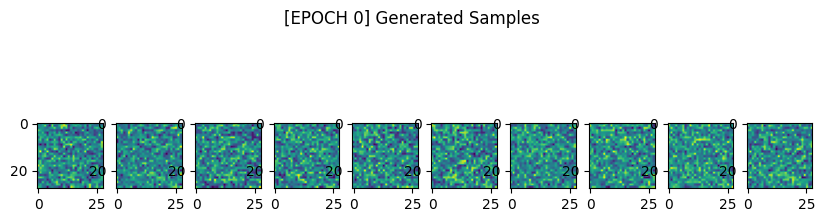

[EPOCH 50] SAMPLED G LOSS : 0.6661804914474487, SAMPLED D LOSS : 0.6505001783370972


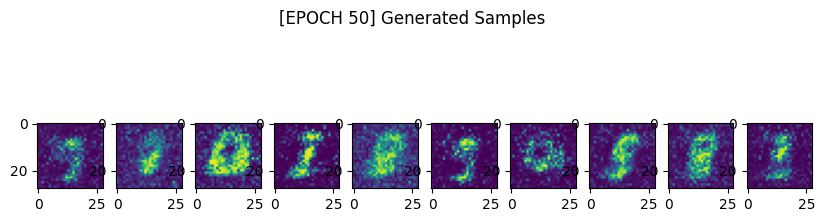

[EPOCH 100] SAMPLED G LOSS : 0.7526378631591797, SAMPLED D LOSS : 0.5940686464309692


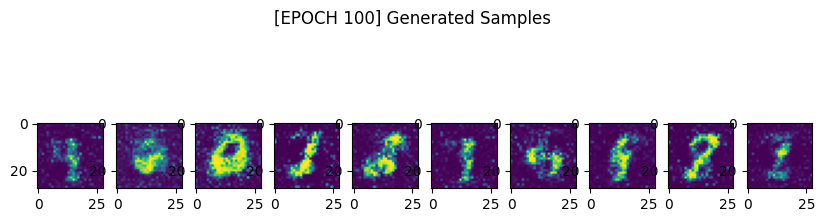

[EPOCH 150] SAMPLED G LOSS : 0.8546971678733826, SAMPLED D LOSS : 0.5618239641189575


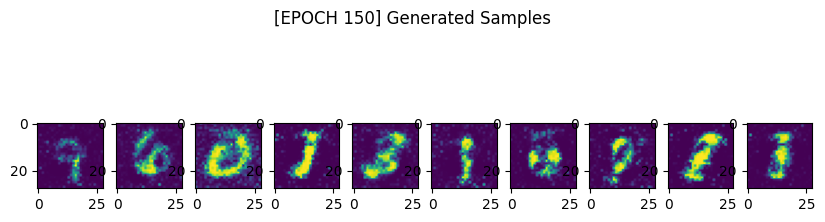

[EPOCH 200] SAMPLED G LOSS : 0.8476387858390808, SAMPLED D LOSS : 0.578039824962616


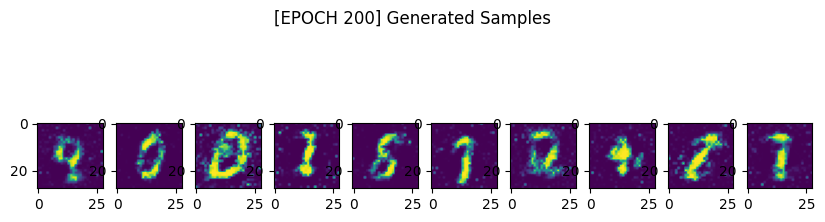

[EPOCH 250] SAMPLED G LOSS : 0.8727579712867737, SAMPLED D LOSS : 0.5647090673446655


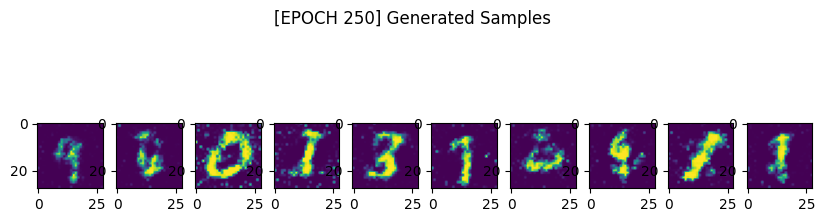

[EPOCH 300] SAMPLED G LOSS : 0.8941540122032166, SAMPLED D LOSS : 0.5780665874481201


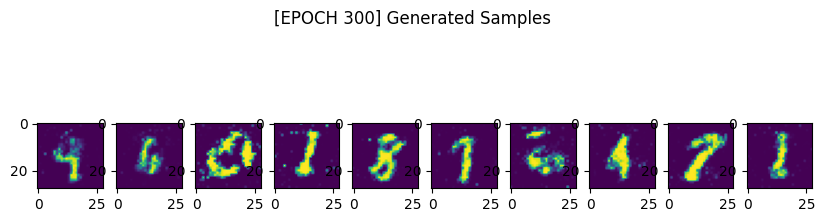

[EPOCH 350] SAMPLED G LOSS : 0.8591768145561218, SAMPLED D LOSS : 0.6189271211624146


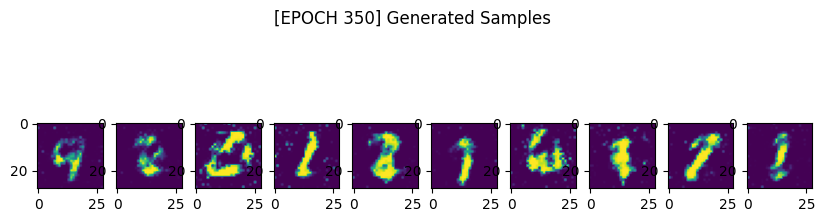

[EPOCH 400] SAMPLED G LOSS : 0.9034069776535034, SAMPLED D LOSS : 0.635040283203125


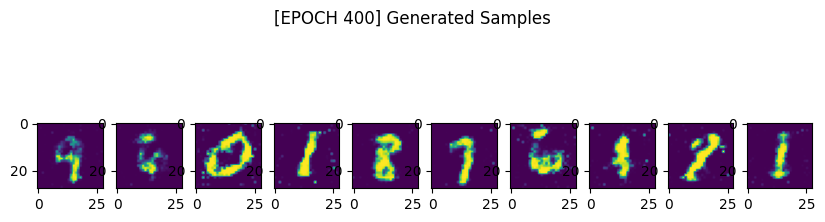

[EPOCH 450] SAMPLED G LOSS : 0.8270186185836792, SAMPLED D LOSS : 0.6395250558853149


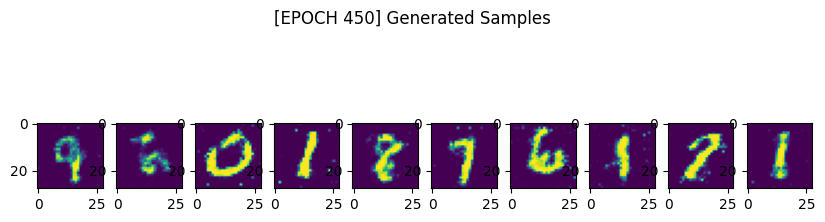

[EPOCH 500] SAMPLED G LOSS : 0.8207899928092957, SAMPLED D LOSS : 0.6381161212921143


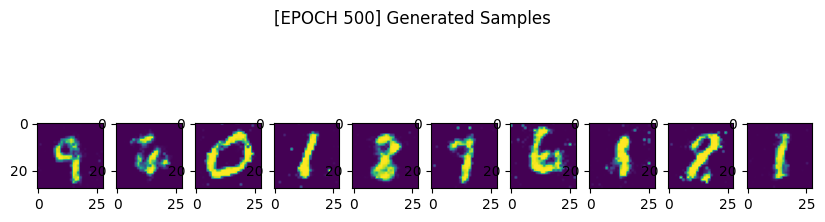

[EPOCH 550] SAMPLED G LOSS : 0.7872726321220398, SAMPLED D LOSS : 0.6513676643371582


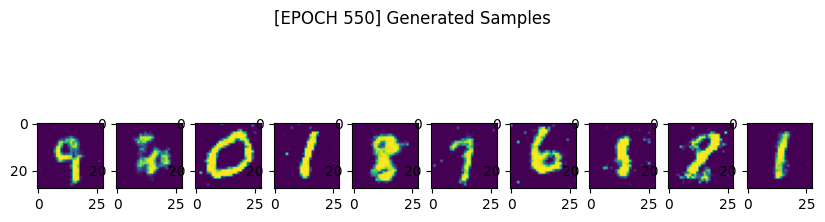

[EPOCH 600] SAMPLED G LOSS : 0.8307248950004578, SAMPLED D LOSS : 0.6509069204330444


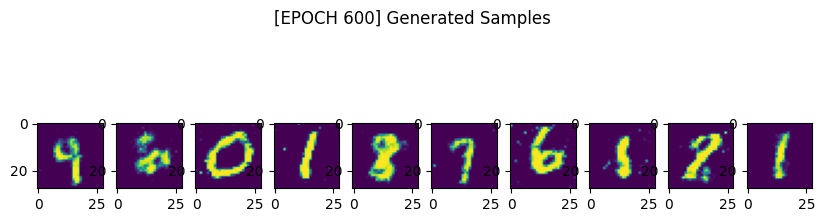

[EPOCH 650] SAMPLED G LOSS : 0.8153845071792603, SAMPLED D LOSS : 0.6474995017051697


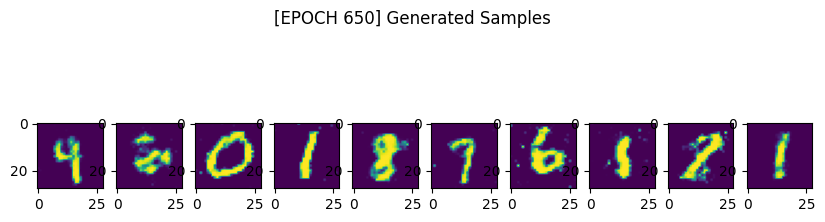

[EPOCH 700] SAMPLED G LOSS : 0.7839230298995972, SAMPLED D LOSS : 0.6582905054092407


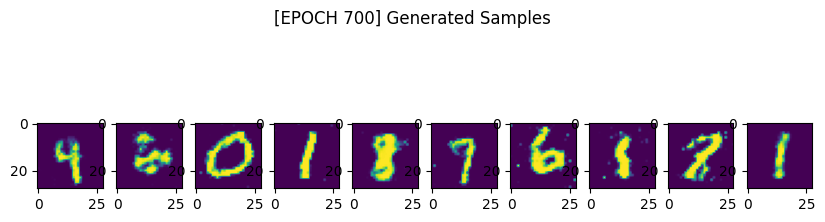

[EPOCH 750] SAMPLED G LOSS : 0.7846034169197083, SAMPLED D LOSS : 0.6514220237731934


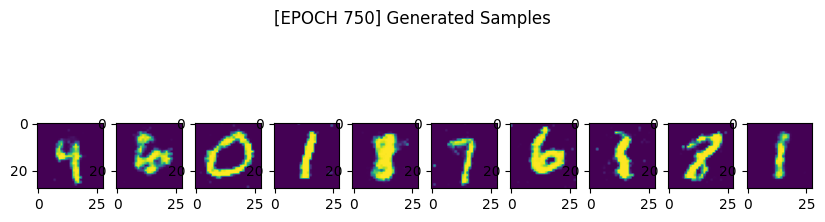

[EPOCH 800] SAMPLED G LOSS : 0.7865170836448669, SAMPLED D LOSS : 0.6522314548492432


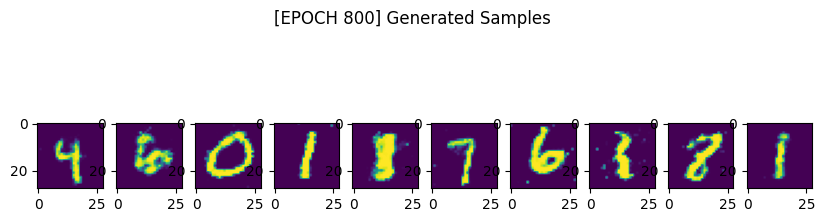

[EPOCH 850] SAMPLED G LOSS : 0.7738859057426453, SAMPLED D LOSS : 0.6541101932525635


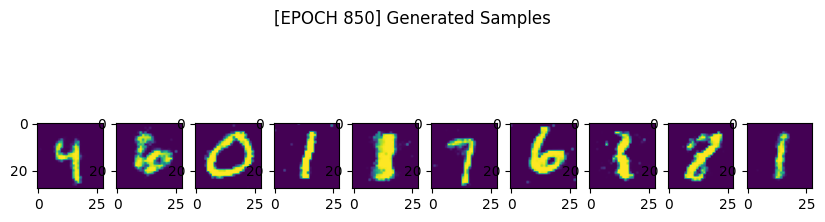

[EPOCH 900] SAMPLED G LOSS : 0.7713994383811951, SAMPLED D LOSS : 0.658480167388916


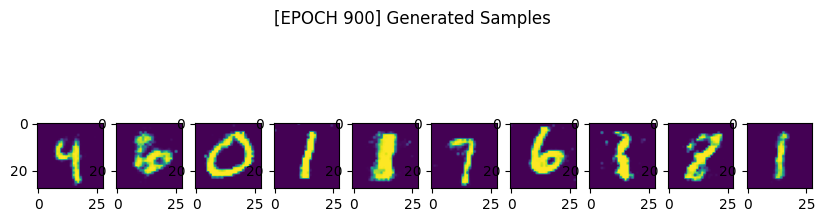

[EPOCH 950] SAMPLED G LOSS : 0.7993884682655334, SAMPLED D LOSS : 0.6609236001968384


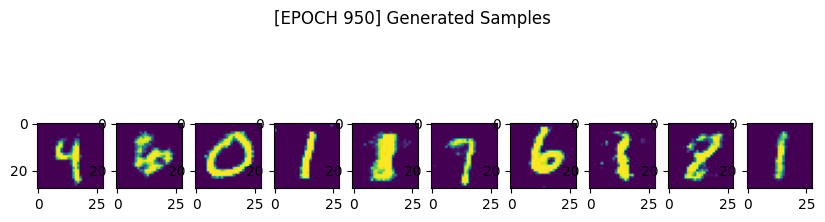

In [ ]:
max_epoch = 1000

for epoch in tqdm(range(max_epoch)):
    for idx, sample in enumerate(train_dataloader):
        g_loss, d_loss = train(generator, discriminator, gen_optimizer, dis_optimizer, dim_z, sample)
    if epoch % 50 == 0:
        print('[EPOCH {}] SAMPLED G LOSS : {}, SAMPLED D LOSS : {}'.format(epoch, g_loss, d_loss))
        fig, ax = plt.subplots(1, 10, figsize=(10, 3))
        for i in range(10):
            ax[i].imshow(test(generator, img_size, dim_z, seed=i))
        plt.suptitle('[EPOCH {}] Generated Samples'.format(epoch))
        plt.pause(0.1)


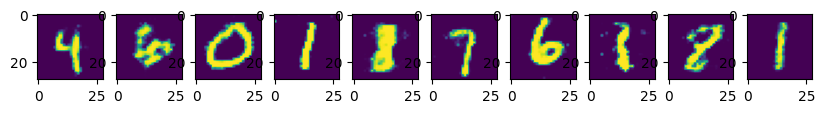

In [ ]:
fig, ax = plt.subplots(1, 10, figsize=(10, 3))
for i in range(10):
    ax[i].imshow(test(generator, img_size, dim_z, seed=i))
